In [20]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms

In [21]:
def train_BasicGAN(generator, discriminator, dataloader, lr=0.0001, criterion=None,
                   latent_dim: int = 100, n_epochs: int = 20, plotit=False):
    

    if criterion is None:
        criterion = nn.BCEWithLogitsLoss() 

    d_losses, g_losses = [], []
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(n_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            batch_size = imgs.size(0)

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            z = torch.randn(batch_size, latent_dim)
            fake_imgs = generator(z)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_loss = criterion(discriminator(imgs), real_labels)
            fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            g_loss = criterion(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        #print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    if plotit:
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label="Discriminator Loss")
        plt.plot(g_losses, label="Generator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()




import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
import numpy as np
from collections import defaultdict

def train_DiaGAN(generator, discriminator, data, lr=0.0005, latent_dim=100, n_epochs=200,
                 phase1_ratio=0.9, batch_size=128, window_size=50, k=1.0,
                 min_clip=0.01, max_ratio=50):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    criterion = nn.BCEWithLogitsLoss()  # use logits (SNGAN-friendly)

    # Detect if image data (e.g., MNIST shape: [B, 1, 28, 28])
    is_image = (data.ndim > 2)
    tensor_data = torch.tensor(data, dtype=torch.float32)

    # Detect if discriminator expects 4D conv inputs
    conv_mode = any(isinstance(m, nn.Conv2d) for m in discriminator.modules())

    dataset_size = len(tensor_data)
    ldr_dict = defaultdict(list)

    for epoch in range(n_epochs):
        in_phase1 = epoch < int(phase1_ratio * n_epochs)

        #Phase 1: uniform sampling
        if in_phase1:
            sampler = torch.utils.data.RandomSampler(tensor_data)

        #Phase 2: weighted sampling by LDRM + k * sqrt(LDRV)
        else:
            scores = []
            for i in range(dataset_size):
                ldrs = np.array(ldr_dict[i][-window_size:])
                if len(ldrs) == 0:
                    scores.append(1.0)
                else:
                    ldrm = np.mean(ldrs)
                    ldrv = np.var(ldrs)
                    score = ldrm + k * np.sqrt(ldrv)
                    scores.append(score)

            scores = np.clip(scores, a_min=min_clip, a_max=min_clip * max_ratio)
            probs = scores / scores.sum()
            sampler = WeightedRandomSampler(probs, num_samples=dataset_size, replacement=True)

        dataloader = DataLoader(TensorDataset(tensor_data), batch_size=batch_size, sampler=sampler)

        for real_batch, in dataloader:
            real_imgs = real_batch.to(device)
            bs = real_imgs.size(0)

            real_labels = torch.ones(bs, 1, device=device)
            fake_labels = torch.zeros(bs, 1, device=device)

            z = torch.randn(bs, latent_dim, device=device)
            fake_imgs = generator(z)

            # Choose input shape depending on model type
            if conv_mode:
                real_input = real_imgs
                fake_input = fake_imgs
            else:
                real_input = real_imgs.view(bs, -1)
                fake_input = fake_imgs.view(bs, -1)

            # Discriminator step
            d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
            d_optimizer.zero_grad()
            real_out = discriminator(real_input)
            fake_out = discriminator(fake_input.detach())
            d_loss = criterion(real_out, real_labels) + criterion(fake_out, fake_labels)
            d_loss.backward()
            d_optimizer.step()

            # Generator step
            g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
            g_optimizer.zero_grad()
            fake_out = discriminator(fake_input)
            g_loss = criterion(fake_out, real_labels)
            g_loss.backward()
            g_optimizer.step()

        # --- Track LDR values ---
        with torch.no_grad():
            D_x = discriminator(tensor_data.to(device) if not conv_mode else tensor_data.to(device)).squeeze()
            eps = 1e-6
            D_x_sigmoid = torch.sigmoid(D_x)  # for LDR calc even tho BCEWithLogits used
            LDR_x = torch.log(D_x_sigmoid / (1 - D_x_sigmoid + eps)).cpu().numpy()
            for i in range(dataset_size):
                ldr_dict[i].append(LDR_x[i])

        if epoch % 10 == 0:
            print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    return generator


In [22]:
import torch
import torch.nn as nn

import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(img_channels, 64, 4, stride=2, padding=1)),  # 28 → 14
            nn.LeakyReLU(0.2),

            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),  # 14 → 7
            nn.LeakyReLU(0.2),

            nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, stride=2, padding=1)),  # 7 → 4
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(256 * 4 * 4, 1))
            # No Sigmoid!
        )

    def forward(self, x):
        return self.net(x)



    
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True),

            nn.Unflatten(1, (256, 7, 7)),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 14x14 → 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


In [23]:
import os 
from torch.utils.data import Dataset
def load_MNISTdata():
    data_dir = os.path.join(os.getcwd(), "..", "data", "raw")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  
    ])

    train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader


class ColoredMNIST(Dataset):
    def __init__(self, mnist_data, minority_ratio=0.1):
        """
        Custom Colored MNIST dataset that assigns red to majority and green to a specified minority group.

        Args:
            mnist_data (torchvision.datasets.MNIST): Preloaded MNIST dataset.
            minority_ratio (float): Fraction of samples to be colored green (0 to 1).
        """
        super().__init__()
        self.images, self.labels = mnist_data.data, mnist_data.targets  # Extract images n labels
        self.images = self.images.unsqueeze(1).float() / 255.0

        total_samples = len(self.images)
        num_minority = int(total_samples * minority_ratio)  # Define the number of green samples

        indices = torch.randperm(total_samples)  

        # Create empty color channels (N, 3, 28, 28)
        self.colors = torch.zeros((total_samples, 3, 28, 28))  

        # Majority samples: Red (R,0,0)
        self.colors[indices[num_minority:], 0] = self.images[indices[num_minority:]].squeeze(1)  # Red channel

        # Minority samples: Green (0,G,0)
        self.colors[indices[:num_minority], 1] = self.images[indices[:num_minority]].squeeze(1)  # Green channel

        self.colors = (self.colors - 0.5) * 2

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img, label = self.colors[idx], self.labels[idx]
        return img, label
    

def get_colored_mnist_dataloader(mnist_dataset, batch_size=128, minority_ratio=0.1):
    dataset = ColoredMNIST(mnist_dataset, minority_ratio=minority_ratio)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def loader_to_data(train_loader):
    all_imgs = []
    for imgs, _ in train_loader:
        all_imgs.append(imgs)
    data = torch.cat(all_imgs, dim=0).numpy()  
    print(f"Loaded: {data.shape}")
    return data

In [13]:
import torch.nn as nn
import torch

class ColoredMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # 28x28 → 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 → 14x14

            nn.Conv2d(32, 64, 3, padding=1),  # 14x14 → 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 → 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        feats = self.features(x)
        logits = self.classifier(feats)
        return logits, feats.view(x.size(0), -1)  # logits, feature_vector


In [27]:



from torch.utils.data import DataLoader
import torch.nn.functional as F

def train_colored_mnist_classifier(train_loader, n_epochs=5, save_path="colored_mnist_classifier.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



    
    model = ColoredMNISTClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print("Training Colored MNIST Classifier...")
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{n_epochs} Loss: {avg_loss:.4f}")

    # Optional: Save model
    torch.save(model.state_dict(), save_path)
    print(f"Saved classifier to {save_path}")
    return model




In [28]:
train_loader, _ = load_MNISTdata()
colored_mnist_loader = get_colored_mnist_dataloader(train_loader.dataset, batch_size=128, minority_ratio=0.2)
X_mnist = loader_to_data(colored_mnist_loader)

Loaded: (60000, 3, 28, 28)


In [29]:
classifier = train_colored_mnist_classifier(colored_mnist_loader)

Training Colored MNIST Classifier...
Epoch 1/5 Loss: 0.2638
Epoch 2/5 Loss: 0.0642
Epoch 3/5 Loss: 0.0448
Epoch 4/5 Loss: 0.0349
Epoch 5/5 Loss: 0.0263
Saved classifier to colored_mnist_classifier.pth


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm



def plot_generated_colored_images(generator, latent_dim=100, num_images=16, device="cpu", title="Generated Samples", plot_it=False):
    """
  
    """
    generator.eval()
    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        fake_imgs = generator(z).cpu()

    # Ensure range [0, 1] for visualization
    fake_imgs = (fake_imgs + 1) / 2  # Assuming Tanh output → scale to [0, 1]

    if plot_it:
        # Plot in grid
        nrow = int(np.sqrt(num_images))
        grid_img = torchvision.utils.make_grid(fake_imgs, nrow=nrow, normalize=False)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
        plt.axis("off")
        plt.title(title)
        plt.show()

    return fake_imgs



def get_classifier_features(classifier, data, batch_size=128):
    classifier.eval()
    device = next(classifier.parameters()).device
    features = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = torch.tensor(data[i:i+batch_size], dtype=torch.float32, device=device)

            if batch.ndim == 3:
                batch = batch.unsqueeze(1)  # (N, H, W) → (N, 1, H, W)

            if batch.shape[1] == 1 and next(classifier.parameters()).shape[1] == 3:
                batch = batch.repeat(1, 3, 1, 1)  # grayscale → RGB for classifier

            _, feats = classifier(batch)
            features.append(feats.cpu())
    return torch.cat(features, dim=0).numpy()

def compute_fid(real_feats, fake_feats):
    mu1, mu2 = real_feats.mean(0), fake_feats.mean(0)
    sigma1 = np.cov(real_feats, rowvar=False)
    sigma2 = np.cov(fake_feats, rowvar=False)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_precision_recall(real_images, generated_images, k=3, eps=0.1):
    import numpy as np
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import normalize

    def preprocess(images):
        if 'torch' in str(type(images)):
            images = images.detach().cpu().numpy()

        images = images.astype(np.float32)

        if images.ndim == 4:  # (N, C, H, W)
            images = images.reshape(images.shape[0], -1)
        elif images.ndim == 3:  # (N, H, W)
            images = images.reshape(images.shape[0], -1)
        elif images.ndim == 2:
            pass
        else:
            raise ValueError(f"Unsupported image shape: {images.shape}")

        return normalize(images)

    real_vecs = preprocess(real_images)
    gen_vecs = preprocess(generated_images)

    nn_real = NearestNeighbors(n_neighbors=k).fit(real_vecs)
    dists_real_to_gen, _ = nn_real.kneighbors(gen_vecs)
    precision = np.mean(np.min(dists_real_to_gen, axis=1) < eps)

    nn_gen = NearestNeighbors(n_neighbors=k).fit(gen_vecs)
    dists_gen_to_real, _ = nn_gen.kneighbors(real_vecs)
    recall = np.mean(np.min(dists_gen_to_real, axis=1) < eps)

    return precision, recall



def evaluate_gan(gen_images, classifier, real_data, device="cpu", eps=0.4):
    classifier = classifier.to(device)
    
    # Ensure correct shape and channel match
    def to_tensor(imgs):
        imgs = torch.tensor(imgs, dtype=torch.float32)
        if imgs.ndim == 3:
            imgs = imgs.unsqueeze(1)  # (N, H, W) → (N, 1, H, W)
        return imgs

    real_tensor = to_tensor(real_data)
    fake_tensor = to_tensor(gen_images)

    # Match channels for pixel-based metrics
    if real_tensor.shape[1] != fake_tensor.shape[1]:
        if real_tensor.shape[1] == 1:
            real_tensor = real_tensor.repeat(1, 3, 1, 1)
        if fake_tensor.shape[1] == 1:
            fake_tensor = fake_tensor.repeat(1, 3, 1, 1)

    # Feature extraction for FID
    real_feats = get_classifier_features(classifier, real_tensor)
    fake_feats = get_classifier_features(classifier, fake_tensor)

    # Pixel-space precision/recall (optional)
    prec, rec = compute_precision_recall(real_feats, fake_feats, eps=eps)
    fid = compute_fid(real_feats, fake_feats)

    return {"Precision": prec, "Recall": rec, "FID": fid}

In [ ]:
G = Generator(z_dim=100, img_channels=3)
D = Discriminator(img_channels=3)

trained_G = train_BasicGAN(
    generator=G,
    discriminator=D,
    dataloader=colored_mnist_loader,
    lr=0.0002,
    latent_dim=100,
    n_epochs=100  
)

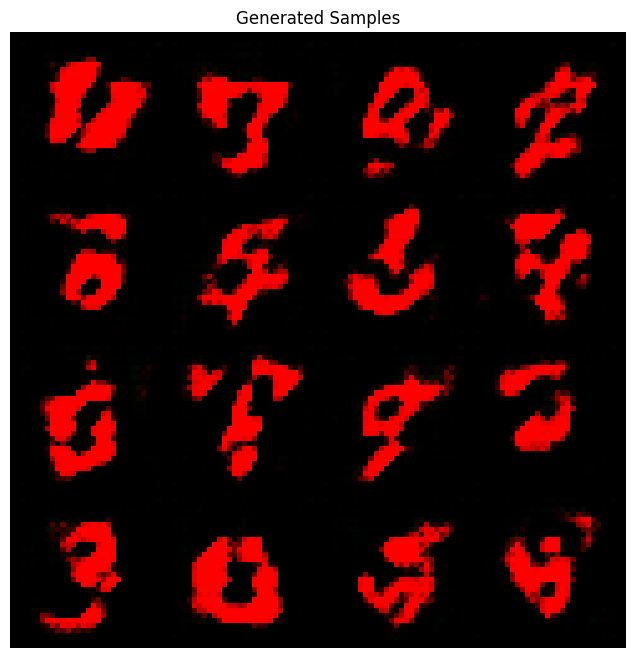

In [5]:
_ = plot_generated_colored_images(G, plot_it=True)

In [6]:
gen_images = plot_generated_colored_images(G, num_images=1000, plot_it=False)

In [ ]:
results = {}
results["BasicGAN"] = evaluate_gan(gen_images, classifier=classifier, real_data=X_mnist[:1000], eps=0.4)
results["BasicGAN"]

C:\Users\sarpg\OneDrive\Masaüstü\Generative Neural Networks\DiaGAN-Project\src\evaluation\evaluate_colored.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.float32)
C:\Users\sarpg\OneDrive\Masaüstü\Generative Neural Networks\DiaGAN-Project\src\evaluation\evaluate_colored.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[i:i+batch_size], dtype=torch.float32, device=device)


{'Precision': np.float64(0.0),
 'Recall': np.float64(0.0),
 'FID': np.float64(1224.2291294880515)}

In [ ]:
diaG = Generator(z_dim=100, img_channels=3)
diaD = Discriminator(img_channels=3)

trained_diaG = train_DiaGAN(
    generator=diaG,
    discriminator=diaD,
    data=X_mnist,
    latent_dim=100,
    n_epochs=10,
    phase1_ratio=0.5,
    k=0.5,
    batch_size=128
)

[Epoch 0] D Loss: 1.2677 | G Loss: 0.9601


In [9]:
_ = plot_generated_colored_images(diaG, plot_it=True)

NameError: name 'diaG' is not defined

In [ ]:
gen_images_dia=plot_generated_colored_images(diaG, num_images=1000, plot_it=False)
results["DiaGAN"] = evaluate_gan(gen_images_dia, classifier, real_data=X_mnist[:1000])
results["DiaGAN"]

C:\Users\sarpg\OneDrive\Masaüstü\Generative Neural Networks\DiaGAN-Project\src\evaluation\evaluate_colored.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.float32)
C:\Users\sarpg\OneDrive\Masaüstü\Generative Neural Networks\DiaGAN-Project\src\evaluation\evaluate_colored.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[i:i+batch_size], dtype=torch.float32, device=device)


{'Precision': np.float64(0.0),
 'Recall': np.float64(0.0),
 'FID': np.float64(998.6629604583346)}